# Regression on Ames Housing Dataset

#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

#### Loading the data

In [3]:
url = "http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls"
data = pd.read_excel(url)

**Let's visualize the univariate distribution of each continuous variable, and the distribution of the target.**

Let us first isolate the continuous columns:

I used the data dictionary found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt to gain intuition on the possible continuous columns. I then examined the potential columns one by one and kept the ones that could be considered as continuous.

In [4]:
continuous = ['Lot Frontage',
              'Lot Area',
              'Mas Vnr Area',
              'BsmtFin SF 1',
              'BsmtFin SF 2',
              'Bsmt Unf SF',
              'Total Bsmt SF',
              '1st Flr SF',
              '2nd Flr SF',
              'Low Qual Fin SF',
              'Gr Liv Area',
              'Garage Area',
              'Wood Deck SF',
              'Open Porch SF',
              'Enclosed Porch',
              '3Ssn Porch',
              'Screen Porch',
              'Pool Area',
              'Misc Val']

In [5]:
target = 'SalePrice'

Let us now plot the univariate distribution of each continuous variable, not showing the `NaN` values:

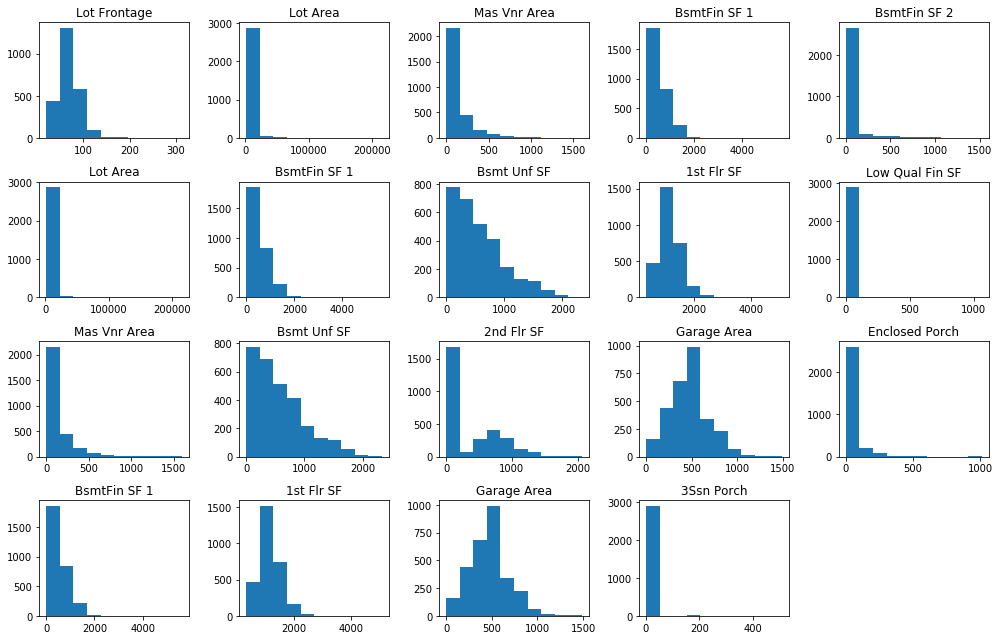

In [6]:
f, ax = plt.subplots(4, 5, figsize=(14, 9))
for i in range(4):
    for j in range(5):
        if((i+1)*(j+1) < 20):
            var_name = continuous[(i+1)*(j+1)-1]
            var_not_nan = data.loc[~np.isnan(data[var_name]), var_name]
            ax[i, j].hist(var_not_nan)
            ax[i, j].set_title(continuous[(i+1)*(j+1)-1])
f.delaxes(ax[3,4])
plt.tight_layout()

Let us plot the distribution of the target variable:

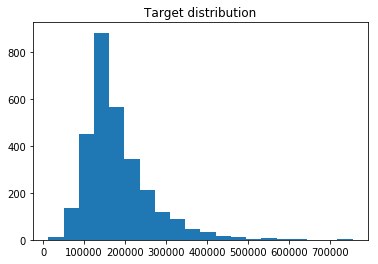

In [7]:
plt.hist(data[target], bins=20)
plt.title('Target distribution')
plt.show()

Depending on the model we wish to implement going forward **it might be a good idea to scale the variables** as they span different intervals.

Many variables also appear to have **outliers**: before scaling one should perhaps explore the data further to investigate the existence of such outliers and possible reasons. Scaling strategies should depend on the results of such an investigation, one of the safest method, in the absence of new useful information, being using a **robust scaler** (for instance substracting the median and dividing by an interquartile range, rather than a standard scaler).

A number of variables also show **strong skew** (it is likely that there are many 0s, an intuition that can be confirmed by plotting histograms with very small binwidths) and could perhaps be transformed (using a **Box-Cox transformation** for instance) to reduce asymmetry in their distribution before fitting a model on them.

#### Let's visualize the dependency of the target on each continuous feature 

Again, I show only the data that is not `NaN` for the visualization:

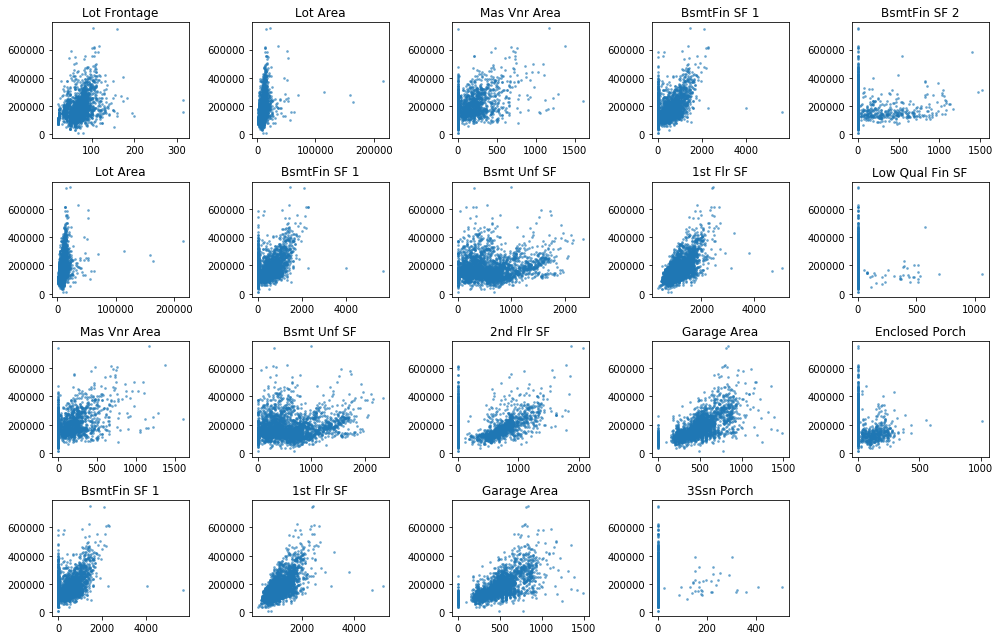

In [8]:
f, ax = plt.subplots(4, 5, figsize=(14, 9))
for i in range(4):
    for j in range(5):
        if((i+1)*(j+1) < 20):
            var_name = continuous[(i+1)*(j+1)-1]
            var_not_nan = data.loc[~np.isnan(data[var_name]), var_name]
            target_not_nan = data.loc[~np.isnan(data[var_name]), target]
            ax[i, j].scatter(var_not_nan, target_not_nan, s=3, alpha=.5)
            ax[i, j].set_title(continuous[(i+1)*(j+1)-1])
f.delaxes(ax[3,4])
plt.tight_layout()

#### Let's split data in training and test set.  For each categorical variable, we will cross-validate a Linear Regression model using just this variable and visualize the three categorical variables that provide the best R^2 value.

Let us first split the data into training and testing sets:

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test, y_train, y_test = train_test_split(data, data['SalePrice'], 
                                                random_state=0)

I keep track of the categorical variables. Looking at the data documentation I consider all variables that are continuous to be categorical variables of interest except `Order` and `PID` which have a one-to-one relation with each record.

In [11]:
categorical = list(set(data.columns) - set(continuous) - {'Order', 'PID'})

Before going any further let us deal with **missing data** for categorical variables in the training set. I will encode it to its own category `N/A`:

In [12]:
train = train.replace(to_replace={var:np.NaN for var in categorical}, 
                      value="N/A")

Now I can cross-validate a Linear Regression model for each categorical variable (one-hot-encoded), storing the R^2 values along the way. I choose to remove `NA` values before fitting the model for each categorical variable independently without any further information on how to possibly impute them:

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [14]:
lin_reg = LinearRegression()
R_2 = []
for var in categorical:
    # casting to string to avoid numerical categories passed
    # to one-hot-encoder
    train[var] = train[var].astype(str)
    encoder = OneHotEncoder(categories=[train[var].unique()])
    # reshaping to be a valid input for `cross_val_score`
    train_var = train[var].values.reshape(-1, 1)
    model = make_pipeline(encoder, lin_reg)
    cross_v = cross_val_score(model, train_var, y_train, cv=5)
    R_2.append(cross_v.mean())  

At this point we note that the method we chose is detrimental to ordinal features in that one-hot-encoding destroys the order of the different levels (they exist in many quality variables as well as date information).

The three largest R^2 scores are:

In [15]:
largest_indices = np.argpartition(R_2, -3)[-3:]
best_R_2 = np.take(R_2, largest_indices)
print(best_R_2)

[0.52173754 0.56125948 0.70730779]


And their corresponding variables:

In [16]:
best_cat = np.take(categorical, largest_indices)
print(best_cat)

['Exter Qual' 'Neighborhood' 'Overall Qual']


Despite their ordinal quality being overlooked in our model, `Exter Qual` and more prominently `Overall Qual` still delivered discriminative information compared to the other categorical variables in the data.

Let us now visualize the counts of those variables:

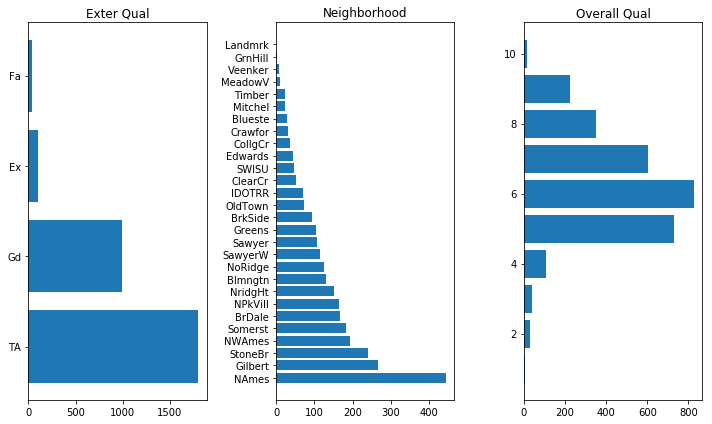

In [17]:
f, ax = plt.subplots(1, 3, figsize=(10, 6))
for i in range(3):
    var_name = best_cat[i]
    ax[i].barh(data[var_name].unique(), width=data[var_name].value_counts())
    ax[i].set_title(var_name)
plt.tight_layout()

#### Let's evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. We will then see whether scaling the data helps performance.

Necessary imports:

In [18]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

I instantiate the models with the default parameters (extending the max number of iterations for Lasso and ElasticNet to avoid convergence warnings):

In [19]:
linear_models = [LinearRegression(), 
                 Ridge(), 
                 Lasso(), 
                 ElasticNet()]

Now I instantiate the column transformer, **imputing continuous missing values** with the variable median (more robust to outliers that were spotted in 1.1), and **one-hot-encoding categorical variables**:

In [20]:
cat_encoder = OneHotEncoder(categories=[train[var].unique() for var in categorical])
preprocess = make_column_transformer((continuous, SimpleImputer(strategy='median')), 
                                     (categorical, cat_encoder))

Before going forward I drop the `Order` and `PID` columns from `train` as I won't need them:

In [21]:
train = train.drop(labels=['Order', 'PID'], axis=1)

Now I can fit the models and evaluate them with cross-validation:

In [22]:
import warnings

In [23]:
# to avoid printing many convergence warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = []
    for model in linear_models:
        pipeline = make_pipeline(preprocess, model)
        val_scores = cross_val_score(pipeline, train, y_train, cv=5)
        scores.append(val_scores.mean())

The mean validation scores are:

In [24]:
print(scores)

[0.7263696035488174, 0.250424118599241, 0.7961321437903909, 0.8185960178681544]


Now, with standard scaling of the continuous features:

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
cont_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
preprocess_scaled = make_column_transformer((continuous, cont_pipeline), 
                                            (categorical, cat_encoder))

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores_scaled = []
    for model in linear_models:
        pipeline = make_pipeline(preprocess_scaled, model)
        val_scores = cross_val_score(pipeline, train, y_train, cv = 5)
        scores_scaled.append(val_scores.mean())

The new scores are:

In [28]:
res = pd.DataFrame({'Scores without scaling': scores, 
                    'Scores with scaling': scores_scaled,
                    'Algorithms': ['OLS', 'Ridge', 'Lasso', 'ElasticNet']})
res = res.set_index('Algorithms')
display(res)

Scores without scaling  Scores with scaling
Algorithms                                             
OLS                       0.726370             0.456161
Ridge                     0.250424             0.862275
Lasso                     0.796132             0.796105
ElasticNet                0.818596             0.832293

Scaling the data helps a lot with Ridge regression but it decreases the accuracy for OLS quite significantly, does not seem to impact Lasso regression much and only slightly improves the score for the Elastic Net procedure - all conclusions keeping in mind that we used the models with no tuning whatsoever.

#### Let's tune the parameters of the models using GridSearchCV. Then we will visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

Necessary import:

In [29]:
from sklearn.model_selection import GridSearchCV

Let us generate the parameter grids I will use to tune the models:

In [30]:
param_grid_ridge = {'ridge__alpha': np.logspace(-3, 3, 7)}
param_grid_lasso = {'lasso__alpha': np.logspace(-3, 3, 7)}
param_grid_net = {'elasticnet__alpha': np.logspace(-3, 3, 7),
                  'elasticnet__l1_ratio': np.linspace(.1, .9, 9)}

I build the three pipelines - with prior scaling for the models that performed better under these conditions:

In [31]:
pip_ridge = make_pipeline(preprocess_scaled, linear_models[1])
pip_lasso = make_pipeline(preprocess, linear_models[2])
pip_net = make_pipeline(preprocess_scaled, linear_models[3])

I can now run the grid searches with cross-validation:

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_ridge = GridSearchCV(pip_ridge, param_grid_ridge, 
                              cv=5, return_train_score=True).fit(train, y_train)
    grid_lasso = GridSearchCV(pip_lasso, param_grid_lasso, 
                              cv=5, return_train_score=True).fit(train, y_train)
    grid_net = GridSearchCV(pip_net, param_grid_net, 
                            cv=5, return_train_score=True).fit(train, y_train)

I fetch the resulting validation scores:

In [33]:
score_ridge = grid_ridge.cv_results_['mean_test_score']
score_lasso = grid_lasso.cv_results_['mean_test_score']
score_net = grid_net.cv_results_['mean_test_score']

For each model I check the best parameters as well as the best validation scores:

In [34]:
print("The best Ridge regularization parameter is " 
      + str(grid_ridge.best_params_['ridge__alpha']))
print("The best Ridge validation score is %.4f"
      %grid_ridge.best_score_)
print("The previous validation score (with default parameters) was %.4f"
      %res.iloc[1, 1])

The best Ridge regularization parameter is 10.0
The best Ridge validation score is 0.8729
The previous validation score (with default parameters) was 0.8623


In [35]:
print("The best Lasso regularization parameter is " 
      + str(grid_lasso.best_params_['lasso__alpha']))
print("The best Lasso validation score is %.4f"
      %grid_lasso.best_score_)
print("The previous validation score (with default parameters) was %.4f"
      %res.iloc[2, 0])

The best Lasso regularization parameter is 100.0
The best Lasso validation score is 0.8711
The previous validation score (with default parameters) was 0.7961


In [36]:
print("The best ElasticNet regularization parameters are " 
      + str(grid_net.best_params_['elasticnet__alpha']) + " (alpha) "
      + str(grid_net.best_params_['elasticnet__l1_ratio']) + "(L1 ratio)")
print("The best ElasticNet validation score is %.4f"%grid_net.best_score_)
print("The previous validation score (with default parameters) was %.4f"
      %res.iloc[3, 1])

The best ElasticNet regularization parameters are 0.1 (alpha) 0.9(L1 ratio)
The best ElasticNet validation score is 0.8739
The previous validation score (with default parameters) was 0.8323


**The results have improved for all three models, most notably for Lasso and ElasticNet regressions, that have improved their R^2 scores respectively, by 0.8 and 0.4**

Such a high L1 ratio suggests that a Lasso regression could provide a good enough model (and more simple!).

Before plotting anything, I store the results for the ElasticNet search in a new dataframe:

In [37]:
res_net = pd.pivot_table(pd.DataFrame(grid_net.cv_results_),
                         values='mean_test_score',
                         index='param_elasticnet__alpha', 
                         columns='param_elasticnet__l1_ratio')

I plot the dependency of the validation score on the parameters for models Ridge and Lasso:

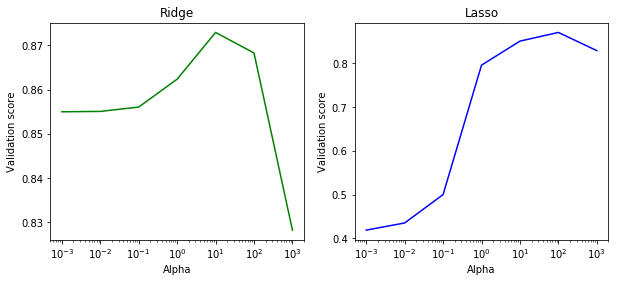

In [38]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(np.logspace(-3, 3, 7), score_ridge, color = "green")
ax[0].set_xscale('log')
ax[0].set_ylabel("Validation score")
ax[0].set_xlabel("Alpha")
ax[0].set_title("Ridge")

ax[1].plot(np.logspace(-3, 3, 7), score_lasso, color = "blue")
ax[1].set_xscale('log')
ax[1].set_ylabel("Validation score")
ax[1].set_xlabel("Alpha")
ax[1].set_title("Lasso")

plt.show()

Now for ElasticNet:

In [39]:
import seaborn as sns

In [40]:
# for numerical stability and visualization purposes
res_net.columns = [ i/10 for i in range(1, 10)]

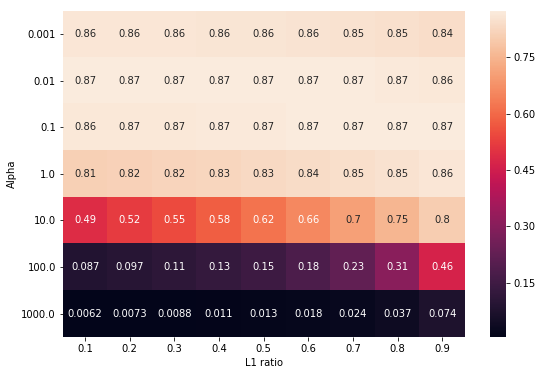

In [41]:
plt.figure(figsize=(9,6))
sns.heatmap(res_net, annot = True)
plt.ylabel("Alpha")
plt.xlabel("L1 ratio")
plt.yticks(rotation=0)
plt.show()

#### Let's visualize the coefficients of the resulting models. Do they agree on which features are important?

Let us create and re-fit the best models:

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ols_best = make_pipeline(preprocess, 
                             LinearRegression()).fit(train, y_train)
    ridge_best = make_pipeline(preprocess_scaled, 
                               Ridge(alpha=10)).fit(train, y_train)
    lasso_best = make_pipeline(preprocess, 
                               Lasso(alpha=100)).fit(train, y_train)
    net_best = make_pipeline(preprocess_scaled,
                             ElasticNet(alpha=.1, l1_ratio=.9)).fit(train, y_train)

Let us now fetch the coefficients for each model.

In [43]:
ols_coef = ols_best.named_steps['linearregression'].coef_
ridge_coef = ridge_best.named_steps['ridge'].coef_
lasso_coef = lasso_best.named_steps['lasso'].coef_
net_coef = net_best.named_steps['elasticnet'].coef_

We can now plot the 10 largest coefficients for each model.

**For the models that were fitted on scaled data (Ridge and ElasticNet), those coefficients reflect how important the features are to predictions made by the models. However, for the two models working on unscaled data (OLS and Lasso) this is not the case.** For instance imagine a predictor v1 with values in the range (1000,2000) and another v2 with values in (1,10). Let's say the coefficient extracted from the OLS model for v1 was w1=1 and the one for v2 was w2=10. One might be tempted to say that v2 was considered more important by the model but actually v2's contribution to predictions is of the order of w2*(1,10)=(10,100) while v1's contribution is of the order of w1*(1000,2000)=(1000,2000) which is one or two orders of magnitude higher than v2!

Nevertheless, **if there are less than 10 coefficients that ended being non-zero for the Lasso model, we will be able to say that those correspond to the most important features of this model**.

We get the 20 largest coefficients (absolute values) for each model as well as the associated variables (remember that variables don't exactly correspond to the original predictors in the dataset because of one-hot-encoding):

In [44]:
ols_indices = np.argsort(-np.absolute(ols_coef))[:10]
ridge_indices = np.argsort(-np.absolute(ridge_coef))[:10]
lasso_indices = np.argsort(-np.absolute(lasso_coef))[:10]
net_indices = np.argsort(-np.absolute(net_coef))[:10]

In [45]:
ols_largest_coef = ols_coef[ols_indices]
ridge_largest_coef = ridge_coef[ridge_indices]
lasso_largest_coef = lasso_coef[lasso_indices]
net_largest_coef = net_coef[net_indices]

We plot feature importance:

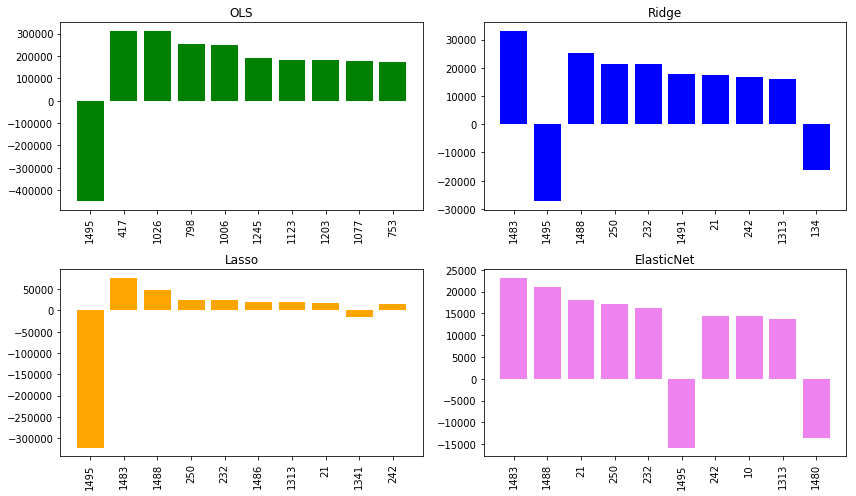

In [46]:
f, ax = plt.subplots(2, 2, figsize=(12, 7))

ax[0, 0].bar(range(1, 11), ols_largest_coef, color = "green")
ax[0, 0].set_xticks(range(1, 11))
ax[0, 0].set_xticklabels(ols_indices, rotation = 90)
ax[0, 0].set_title("OLS")

ax[0, 1].bar(range(1, 11), ridge_largest_coef, color = "blue")
ax[0, 1].set_xticks(range(1, 11))
ax[0, 1].set_xticklabels(ridge_indices, rotation = 90)
ax[0, 1].set_title("Ridge")

ax[1, 0].bar(range(1, 11), lasso_largest_coef, color = "orange")
ax[1, 0].set_xticks(range(1, 11))
ax[1, 0].set_xticklabels(lasso_indices, rotation = 90)
ax[1, 0].set_title("Lasso")

ax[1, 1].bar(range(1, 11), net_largest_coef, color = "violet")
ax[1, 1].set_xticks(range(1, 11))
ax[1, 1].set_xticklabels(net_indices, rotation = 90)
ax[1, 1].set_title("ElasticNet")

plt.tight_layout()
plt.show()

Amongst the 10 most important features for all models:

**Model `OLS` has only one common feature with all others. The other models on the other hand agree with one another on 8 features.**